In [7]:
%matplotlib inline

import pickle
from pathlib import Path
from random import sample

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler

In [31]:
# Data from https://archive.ics.uci.edu/ml/datasets/wine
# One of sklearn built-in datasets

xs, ys = load_wine(return_X_y=True)
x_train, x_valid, y_train, y_valid = train_test_split(xs, ys, test_size=0.3, random_state=0)

std = StandardScaler()
std.fit(x_train)
xt_std = std.transform(x_train)
xv_std = std.transform(x_valid)

pca = PCA(n_components=13)
pca.fit(xt_std)
xt_pca = pca.transform(xt_std)
xv_pca = pca.transform(xv_std)

xt, xv = xt_pca, xv_pca
yt, yv = y_train, y_valid

print('train:', xt.shape)
print('valid:', xv.shape)

train: (124, 13)
valid: (54, 13)


In [14]:
%%time

params = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [1e-2, 1e-1, 1, 10, 100],
    'gamma': [1e-3, 1e-2, 1e-1, 1, 10],    
},

clf = GridSearchCV(SVC(), params, cv=5, scoring='accuracy', 
                   n_jobs=3, return_train_score=True)
clf.fit(xt, yt)
print('Best Param:', clf.best_params_)
print('Best Model Score:', clf.best_estimator_.score(xv, yv))

with open('gridcv.pkl', 'wb') as f:
    pickle.dump(clf, f)

Best Param: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best Model Score: 1.0
CPU times: user 334 ms, sys: 20.3 ms, total: 354 ms
Wall time: 594 ms


In [15]:
with open('gridcv.pkl', 'rb') as f:
    clf = pickle.load(f)
    
data = pd.DataFrame(clf.cv_results_)
data.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_gamma,param_kernel,params,rank_test_score,split0_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.002325,0.000713,0.395161,0.395152,0.01,0.001,rbf,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'rbf'}",57,0.40,...,0.4,0.393939,0.4,0.393939,0.375000,0.40,0.000478,0.000164,0.009877,0.002424
1,0.000978,0.000445,0.967742,0.987919,0.01,0.001,linear,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'linear'}",2,0.92,...,1.0,0.989899,1.0,0.989899,0.958333,0.98,0.000087,0.000038,0.030139,0.003960
2,0.001467,0.000456,0.395161,0.395152,0.01,0.001,poly,"{'C': 0.01, 'gamma': 0.001, 'kernel': 'poly'}",57,0.40,...,0.4,0.393939,0.4,0.393939,0.375000,0.40,0.000580,0.000052,0.009877,0.002424
3,0.001470,0.000489,0.395161,0.395152,0.01,0.01,rbf,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}",57,0.40,...,0.4,0.393939,0.4,0.393939,0.375000,0.40,0.000257,0.000108,0.009877,0.002424
4,0.000841,0.000379,0.967742,0.987919,0.01,0.01,linear,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'linear'}",2,0.92,...,1.0,0.989899,1.0,0.989899,0.958333,0.98,0.000025,0.000013,0.030139,0.003960


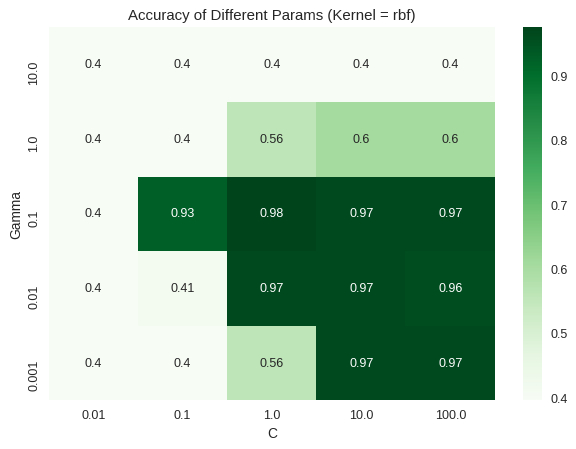

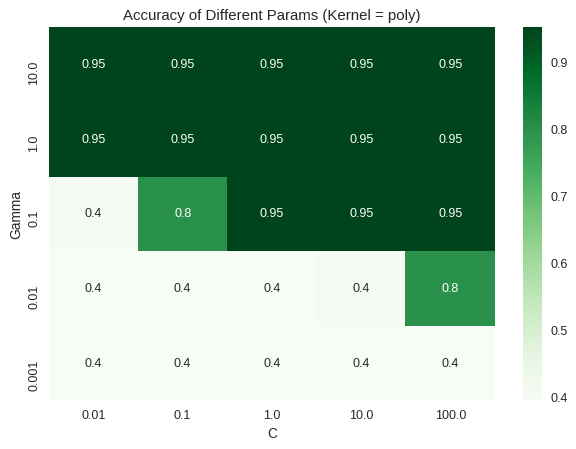

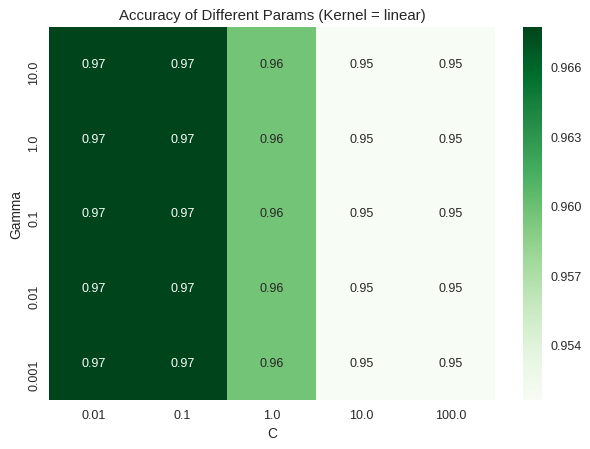

In [56]:
for k in ['rbf', 'poly', 'linear']:
    df = data[data['param_kernel'] == k]
    df = df.pivot(index='param_gamma', columns='param_C', values='mean_test_score')

    fig, ax = plt.subplots(dpi=90)
    sns.heatmap(df, ax=ax, annot=True, cmap=plt.cm.Greens)
    ax.set_xlabel('C')
    ax.set_ylabel('Gamma')
    ax.set_title('Accuracy of Different Params (Kernel = {})'.format(k))
    ax.invert_yaxis()
    fig.savefig(f'svm_{k}.png')
    plt.show()

In [30]:
%%time
rf = RandomForestClassifier(n_estimators=20)
rf.fit(xt, yt)
rf_pred = rf.predict(xv)
rf_acc = rf.score(xv, yv)
print(classification_report(yv, rf_pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97        19
          1       1.00      0.95      0.98        22
          2       1.00      1.00      1.00        13

avg / total       0.98      0.98      0.98        54

CPU times: user 46.7 ms, sys: 981 µs, total: 47.6 ms
Wall time: 47.2 ms


In [29]:
%%time
svm = clf.best_estimator_
svm_pred = svm.predict(xv)
svm_acc = svm.score(xv, yv)
print(classification_report(yv, svm_pred))

1.0
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        19
          1       1.00      1.00      1.00        22
          2       1.00      1.00      1.00        13

avg / total       1.00      1.00      1.00        54

CPU times: user 3.39 ms, sys: 625 µs, total: 4.01 ms
Wall time: 3.88 ms


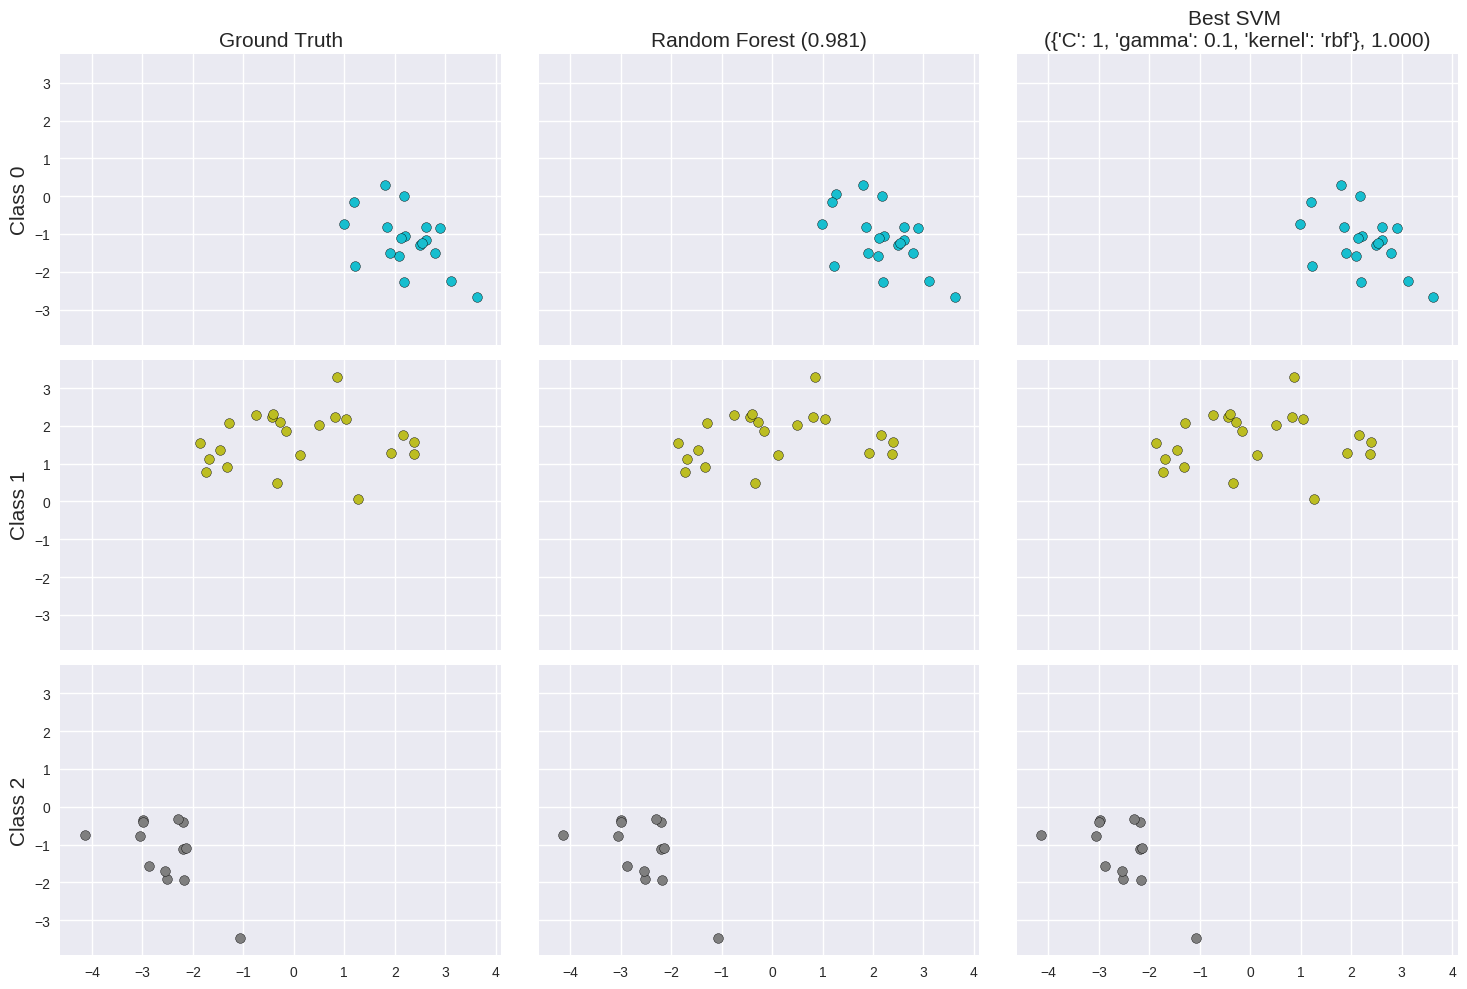

In [27]:
def plot2d(xs, ys, ax):
    cmap = plt.cm.tab10_r
    for y in range(3):
        data = xs[ys == y, :]
        ax[y].scatter(data[:, 0], data[:, 1], c=cmap(y / 10), label=y, edgecolors='k')
    return ax

n_classes = 3
fig, ax = plt.subplots(n_classes, 3, sharex=True, sharey=True, dpi=100, figsize=(15, 10))
plot2d(xv, yv, ax[:, 0])
plot2d(xv, rf_pred, ax[:, 1])
plot2d(xv, svm_pred, ax[:, 2])

col_headers = [f'Class {x}' for x in range(n_classes)]
row_headers = [
    'Ground Truth', 
    f'Random Forest ({rf_acc:.3f})', 
    f'Best SVM \n({clf.best_params_}, {svm_acc:.3f})'
]
for i, rh in enumerate(row_headers):
    ax[0, i].set_title(rh, fontsize=15)
for i, ch in enumerate(col_headers):
    ax[i, 0].set_ylabel(ch, fontsize=15)
    
fig.tight_layout()
fig.savefig('plot.png')
plt.show()

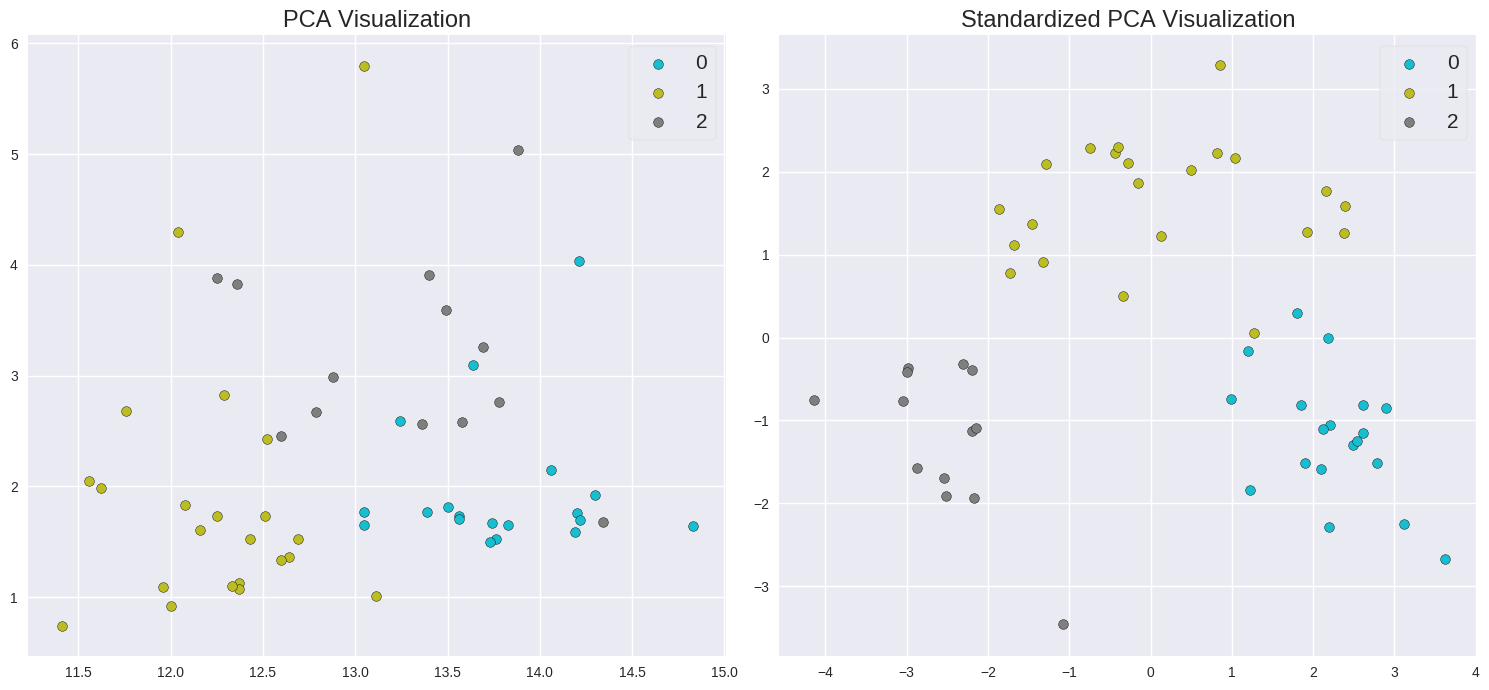

In [57]:
fig, ax = plt.subplots(1, 2, dpi=100, figsize=(15, 7))
ax[0].set_title('PCA Visualization', fontsize=17)
ax[1].set_title('Standardized PCA Visualization', fontsize=17)
cmap = plt.cm.tab10_r
for y in range(3):
    xs = x_valid[yv == y, :]
    ax[0].scatter(xs[:, 0], xs[:, 1], c=cmap(y / 10), label=y, edgecolors='k')
    xs = xv_pca[yv == y, :]
    ax[1].scatter(xs[:, 0], xs[:, 1], c=cmap(y / 10), label=y, edgecolors='k')
ax[0].legend(frameon=True, fontsize=15)
ax[1].legend(frameon=True, fontsize=15)
fig.tight_layout()
fig.savefig('none_vs_std.png')
plt.show()